# LIBARY

In [1]:
!nvidia-smi

Wed Jul 15 12:44:55 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.51.05    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   41C    P8    69W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')
%cd /content/gdrive/My Drive/PPNCKH

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
/content/gdrive/My Drive/PPNCKH


In [3]:
import cv2
import os
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np
import math
import random
import pandas as pd

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import *
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import *
from tensorflow.keras.callbacks import *

In [4]:
INIT_LR = 1e-4
EPOCHS = 40
BS = 8
tta_times = 10
imgSize = 512

# IMG PREPROCESSING

In [5]:
def change_brightness(img):
    value = random.randint(-10,15)
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    h, s, v = cv2.split(hsv)
    
    v = cv2.add(v,value)
    v[v > 255] = 255
    v[v < 0] = 0
    
    final_hsv = cv2.merge((h, s, v))
    img = cv2.cvtColor(final_hsv, cv2.COLOR_HSV2BGR)
    return img

In [6]:
def preprocessing(img):
    img = change_brightness(img)
    return img

# LOAD

In [7]:
trainAug = ImageDataGenerator(rotation_range=20, 
                              horizontal_flip = True,
                              shear_range=0.1,
                              channel_shift_range = 0.05,
                              fill_mode="nearest", 
                              rescale=1./255,
                              preprocessing_function = preprocessing,
                              validation_split=0.2)

testAug = ImageDataGenerator( rescale=1./255,
                              validation_split=0.2)

In [8]:
train_generator = trainAug.flow_from_directory('cropped/',
                                               target_size=(imgSize, imgSize),
                                               batch_size=BS,
                                               class_mode='categorical', 
                                               subset='training')

test_generator = testAug.flow_from_directory('cropped/',
                                              target_size=(imgSize, imgSize),
                                              batch_size=BS,
                                              class_mode='categorical', 
                                              subset='validation')

Found 2325 images belonging to 3 classes.
Found 580 images belonging to 3 classes.


# MODEL

In [9]:
baseModel = DenseNet201(weights="imagenet", include_top=False, input_tensor=Input(shape=(imgSize, imgSize, 3)))
headModel = baseModel.output
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(64, activation="elu")(headModel)
headModel = Dense(16, activation="elu")(headModel)
headModel = Dense(3, activation="softmax")(headModel)
model = Model(inputs=baseModel.input, outputs=headModel)
for layer in baseModel.layers:
    layer.trainable = True

In [10]:
best_val_acc = 0
best_train_acc = 0
def saveModel(epoch,logs):
    val_acc = logs['val_accuracy']
    train_acc = logs['accuracy']
    global best_val_acc
    global best_train_acc

    if val_acc > best_val_acc:
        best_val_acc = val_acc
        model.save('model_densenet201_v2.h5')
    elif val_acc == best_val_acc:
        if train_acc > best_train_acc:
            best_train_acc= train_acc
            model.save('model_densenet201_v2.h5')

In [11]:
opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)
model.compile(loss="categorical_crossentropy", optimizer=opt, metrics=["accuracy"])
H = model.fit_generator(
    train_generator,
    steps_per_epoch=train_generator.samples // BS,
    validation_data=test_generator,
    validation_steps=test_generator.samples // BS,
    callbacks= [LambdaCallback(on_epoch_end=saveModel),
#              EarlyStopping(monitor='val_accuracy', patience=3),
#              ReduceLROnPlateau(monitor='val_accuracy', factor=0.5,patience=4),
              ],
    epochs=EPOCHS)

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/40
290/290 [==============================] - 437s 2s/step - loss: 0.5359 - accuracy: 0.8722 - val_loss: 0.4607 - val_accuracy: 0.7865
Epoch 2/40
290/290 [==============================] - 418s 1s/step - loss: 0.1720 - accuracy: 0.9448 - val_loss: 0.1919 - val_accuracy: 0.9271
Epoch 3/40
290/290 [==============================] - 420s 1s/step - loss: 0.1993 - accuracy: 0.9426 - val_loss: 0.0822 - val_accuracy: 0.9740
Epoch 4/40
290/290 [==============================] - 422s 1s/step - loss: 0.1384 - accuracy: 0.9616 - val_loss: 0.1223 - val_accuracy: 0.9757
Epoch 5/40
290/290 [==============================] - 410s 1s/step - loss: 0.1624 - accuracy: 0.9568 - val_loss: 0.4069 - val_accuracy: 0.8420
Epoch 6/40
290/290 [==============================] - 410s 1s/step - loss: 0.2088 - accuracy: 0.9473 - val_loss: 0.4426 - val_accuracy: 0.8542
Epoch 7/40
290/290 [==============================] - 409s 1s/step

KeyboardInterrupt: ignored

In [ ]:
N = EPOCHS
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, N), H.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy on COVID-19 Dataset")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")

# TEST

In [12]:
model= load_model('model_densenet201_v2.h5')

In [13]:
def wrong_to_list(preds, generator):
    res = []
    for i in range(len(preds)):
        if (preds[i] != generator.labels[i]):
            res.append(generator.filenames[i])
    return res

def show_wrong_img(l):
    fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(24, 10))
    ten_random_samples = pd.Series(l).sample(min(len(l),10)).values
    
    for idx, image in enumerate(ten_random_samples):
        final_path = os.path.join('cropped/', image)
        img = cv2.imread(final_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        axes.ravel()[idx].imshow(img)
        axes.ravel()[idx].axis('off')
    plt.tight_layout()

## WITHOT TTA

### ON TRAIN

In [14]:
train = ImageDataGenerator(rescale=1./255,
                           validation_split=0.2).flow_from_directory('cropped/',
                                                                     target_size=(imgSize, imgSize),
                                                                     batch_size=BS,
                                                                     class_mode='categorical',
                                                                     shuffle = False,
                                                                     subset='training')

Found 2325 images belonging to 3 classes.


In [15]:
CName = {v: k for k, v in train.class_indices.items()}
predIdxs = model.predict_generator(train)
predIdxs = np.argmax(predIdxs, axis=1)
print(classification_report(train.labels, predIdxs, target_names=list(train.class_indices.keys()), digits = 5))

Instructions for updating:
Please use Model.predict, which supports generators.
                 precision    recall  f1-score   support

       COVID-19    1.00000   0.99432   0.99715       176
         NORMAL    0.99808   0.96645   0.98201      1073
Viral Pneumonia    0.96670   0.99814   0.98217      1076

       accuracy                        0.98323      2325
      macro avg    0.98826   0.98630   0.98711      2325
   weighted avg    0.98370   0.98323   0.98323      2325



In [16]:
for i in range(len(predIdxs)):
    if (predIdxs[i] != train.labels[i]):
        print('Filename:',train.filenames[i].split('/')[1], '\t'*(5-math.ceil((len(train.filenames[i].split('/')[1])+3)/8)) +'PRED:', CName[predIdxs[i]], '\t'*(4-(3+len(CName[predIdxs[i]]))//8) + 'TRUE:', CName[train.labels[i]])

Filename: COVID-19(193).png 		PRED: Viral Pneumonia 		TRUE: COVID-19
Filename: NORMAL (1247).png 		PRED: Viral Pneumonia 		TRUE: NORMAL
Filename: NORMAL (1266).png 		PRED: Viral Pneumonia 		TRUE: NORMAL
Filename: NORMAL (1304).png 		PRED: Viral Pneumonia 		TRUE: NORMAL
Filename: NORMAL (1325).png 		PRED: Viral Pneumonia 		TRUE: NORMAL
Filename: NORMAL (1326).png 		PRED: Viral Pneumonia 		TRUE: NORMAL
Filename: NORMAL (1335).png 		PRED: Viral Pneumonia 		TRUE: NORMAL
Filename: NORMAL (1337).png 		PRED: Viral Pneumonia 		TRUE: NORMAL
Filename: NORMAL (146).png 		PRED: Viral Pneumonia 		TRUE: NORMAL
Filename: NORMAL (233).png 		PRED: Viral Pneumonia 		TRUE: NORMAL
Filename: NORMAL (234).png 		PRED: Viral Pneumonia 		TRUE: NORMAL
Filename: NORMAL (248).png 		PRED: Viral Pneumonia 		TRUE: NORMAL
Filename: NORMAL (272).png 		PRED: Viral Pneumonia 		TRUE: NORMAL
Filename: NORMAL (328).png 		PRED: Viral Pneumonia 		TRUE: NORMAL
Filename: NORMAL (33).png 		PRED: Viral Pneumonia 		TRUE: NORMAL
F

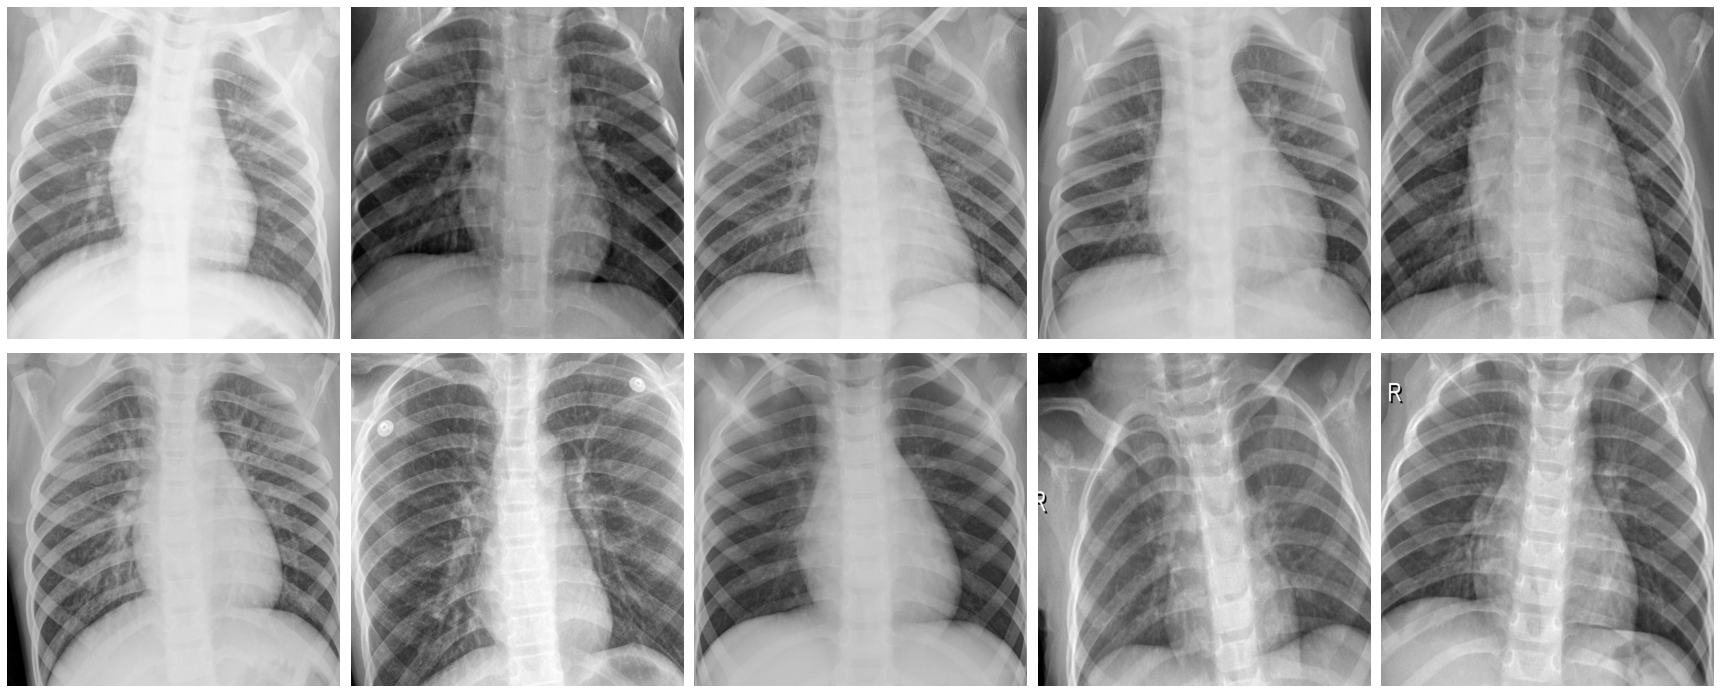

In [17]:
show_wrong_img(wrong_to_list(predIdxs, train))

### ON TEST

In [18]:
test = ImageDataGenerator(rescale=1./255, 
                          validation_split=0.2).flow_from_directory('cropped/',
                                                                    target_size=(imgSize, imgSize),
                                                                    batch_size=BS,
                                                                    class_mode='categorical', 
                                                                    shuffle = False, 
                                                                    subset='validation')

Found 580 images belonging to 3 classes.


In [19]:
CName = {v: k for k, v in test.class_indices.items()}
predIdxs = model.predict_generator(test, verbose=1)
predIdxs = np.argmax(predIdxs, axis=1)

73/73 [==============================] - 30s 409ms/step


In [20]:
print(classification_report(test.labels, predIdxs, target_names=list(test.class_indices.keys()), digits = 5))

                 precision    recall  f1-score   support

       COVID-19    0.97727   1.00000   0.98851        43
         NORMAL    1.00000   0.95896   0.97905       268
Viral Pneumonia    0.96416   1.00000   0.98175       269

       accuracy                        0.98103       580
      macro avg    0.98048   0.98632   0.98310       580
   weighted avg    0.98169   0.98103   0.98100       580



In [21]:
for i in range(len(predIdxs)):
    if (predIdxs[i] != test.labels[i]):
        print('Filename:',test.filenames[i].split('/')[1], '\t'*(5-math.ceil((len(test.filenames[i].split('/')[1])+3)/8)) +'PRED:', CName[predIdxs[i]], '\t'*(4-(3+len(CName[predIdxs[i]]))//8) + 'TRUE:', CName[test.labels[i]])

Filename: NORMAL (1075).png 		PRED: Viral Pneumonia 		TRUE: NORMAL
Filename: NORMAL (1088).png 		PRED: Viral Pneumonia 		TRUE: NORMAL
Filename: NORMAL (1089).png 		PRED: Viral Pneumonia 		TRUE: NORMAL
Filename: NORMAL (1092).png 		PRED: Viral Pneumonia 		TRUE: NORMAL
Filename: NORMAL (1125).png 		PRED: Viral Pneumonia 		TRUE: NORMAL
Filename: NORMAL (1140).png 		PRED: Viral Pneumonia 		TRUE: NORMAL
Filename: NORMAL (1149).png 		PRED: COVID-19 			TRUE: NORMAL
Filename: NORMAL (1159).png 		PRED: Viral Pneumonia 		TRUE: NORMAL
Filename: NORMAL (1206).png 		PRED: Viral Pneumonia 		TRUE: NORMAL
Filename: NORMAL (1219).png 		PRED: Viral Pneumonia 		TRUE: NORMAL
Filename: NORMAL (1230).png 		PRED: Viral Pneumonia 		TRUE: NORMAL


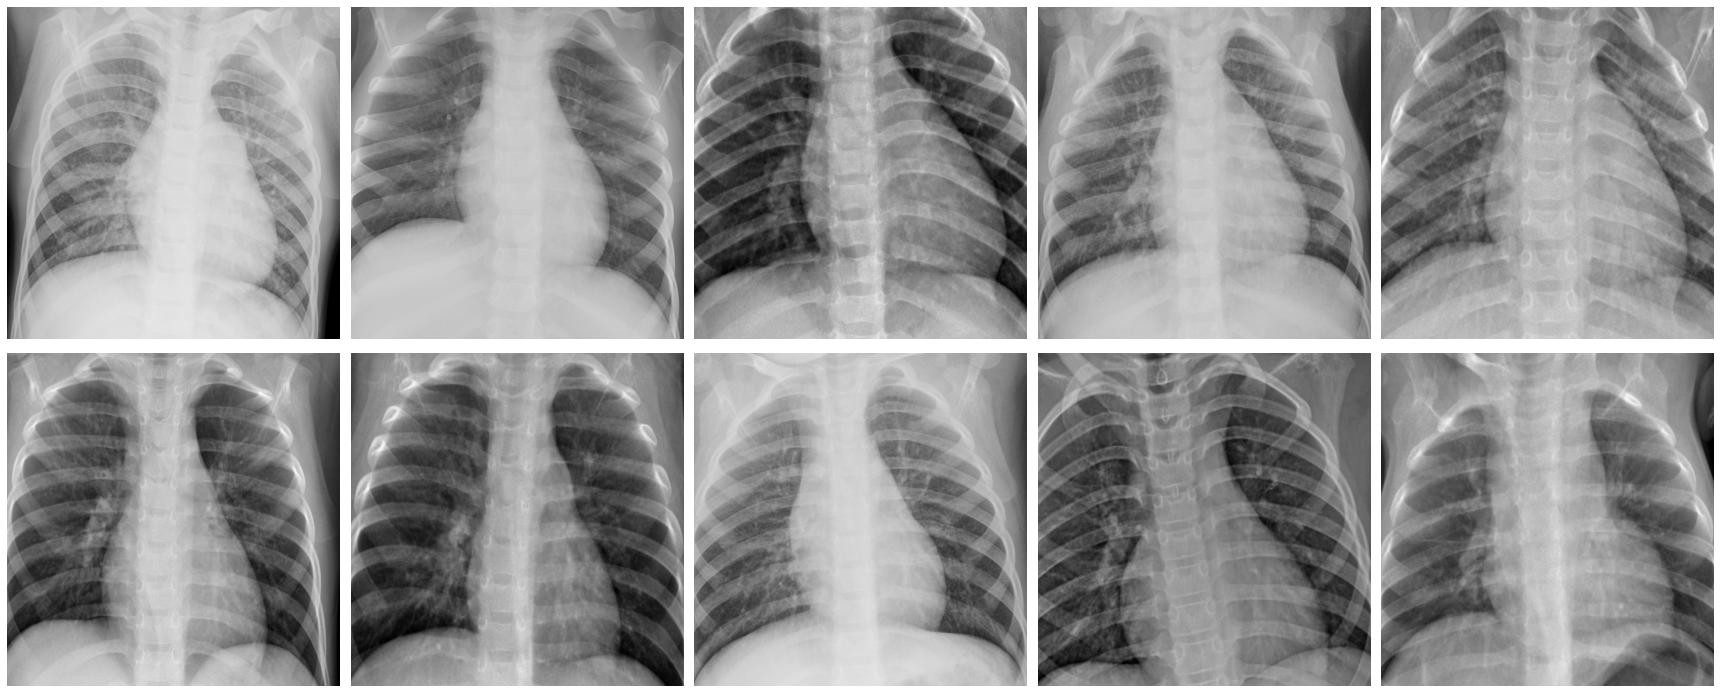

In [22]:
show_wrong_img(wrong_to_list(predIdxs, test))

## WITH TTA

### ON TRAIN

In [23]:
train = ImageDataGenerator(rotation_range=5, 
                          horizontal_flip = True,
                          shear_range=0.05,
                          zoom_range=0.05,
                          channel_shift_range = 0.025,
                          fill_mode="nearest", 
                          rescale=1./255,
                          preprocessing_function = preprocessing,
                          validation_split=0.2).flow_from_directory('cropped/',
                                                                     target_size=(imgSize, imgSize),
                                                                     batch_size=BS,
                                                                     class_mode='categorical',
                                                                     shuffle = False,
                                                                     subset='training')
CName = {v: k for k, v in train.class_indices.items()}
probabilities = []
for i in range(tta_times+1):
    print('TTA Number: ', i, '\n')
    probabilities.append(model.predict(train, verbose=1))
predIdxs = np.mean(probabilities, axis=0)
predIdxs = np.argmax(predIdxs, axis=1)

Found 2325 images belonging to 3 classes.
TTA Number:  0 

291/291 [==============================] - 238s 819ms/step
TTA Number:  1 

291/291 [==============================] - 237s 816ms/step
TTA Number:  2 

291/291 [==============================] - 237s 816ms/step
TTA Number:  3 

291/291 [==============================] - 238s 817ms/step
TTA Number:  4 

291/291 [==============================] - 237s 815ms/step
TTA Number:  5 

291/291 [==============================] - 237s 815ms/step
TTA Number:  6 

291/291 [==============================] - 235s 809ms/step
TTA Number:  7 

291/291 [==============================] - 236s 812ms/step
TTA Number:  8 

291/291 [==============================] - 237s 813ms/step
TTA Number:  9 

291/291 [==============================] - 235s 809ms/step
TTA Number:  10 

291/291 [==============================] - 236s 810ms/step


In [24]:
print(classification_report(train.labels, predIdxs, target_names=list(train.class_indices.keys()), digits = 5))

                 precision    recall  f1-score   support

       COVID-19    0.43350   1.00000   0.60481       176
         NORMAL    1.00000   0.13979   0.24530      1073
Viral Pneumonia    0.60656   0.99721   0.75431      1076

       accuracy                        0.60172      2325
      macro avg    0.68002   0.71234   0.53481      2325
   weighted avg    0.77503   0.60172   0.50808      2325



In [25]:
for i in range(len(predIdxs)):
    if (predIdxs[i] != train.labels[i]):
        print('Filename:',train.filenames[i].split('/')[1], '\t'*(5-math.ceil((len(train.filenames[i].split('/')[1])+3)/8)) +'PRED:', CName[predIdxs[i]], '\t'*(4-(3+len(CName[predIdxs[i]]))//8) + 'TRUE:', CName[train.labels[i]])

Filename: NORMAL (124).png 		PRED: Viral Pneumonia 		TRUE: NORMAL
Filename: NORMAL (1240).png 		PRED: COVID-19 			TRUE: NORMAL
Filename: NORMAL (1242).png 		PRED: Viral Pneumonia 		TRUE: NORMAL
Filename: NORMAL (1243).png 		PRED: Viral Pneumonia 		TRUE: NORMAL
Filename: NORMAL (1244).png 		PRED: Viral Pneumonia 		TRUE: NORMAL
Filename: NORMAL (1245).png 		PRED: Viral Pneumonia 		TRUE: NORMAL
Filename: NORMAL (1246).png 		PRED: Viral Pneumonia 		TRUE: NORMAL
Filename: NORMAL (1247).png 		PRED: Viral Pneumonia 		TRUE: NORMAL
Filename: NORMAL (1248).png 		PRED: Viral Pneumonia 		TRUE: NORMAL
Filename: NORMAL (1249).png 		PRED: Viral Pneumonia 		TRUE: NORMAL
Filename: NORMAL (125).png 		PRED: Viral Pneumonia 		TRUE: NORMAL
Filename: NORMAL (1250).png 		PRED: Viral Pneumonia 		TRUE: NORMAL
Filename: NORMAL (1251).png 		PRED: Viral Pneumonia 		TRUE: NORMAL
Filename: NORMAL (1252).png 		PRED: COVID-19 			TRUE: NORMAL
Filename: NORMAL (1253).png 		PRED: Viral Pneumonia 		TRUE: NORMAL
Filename:

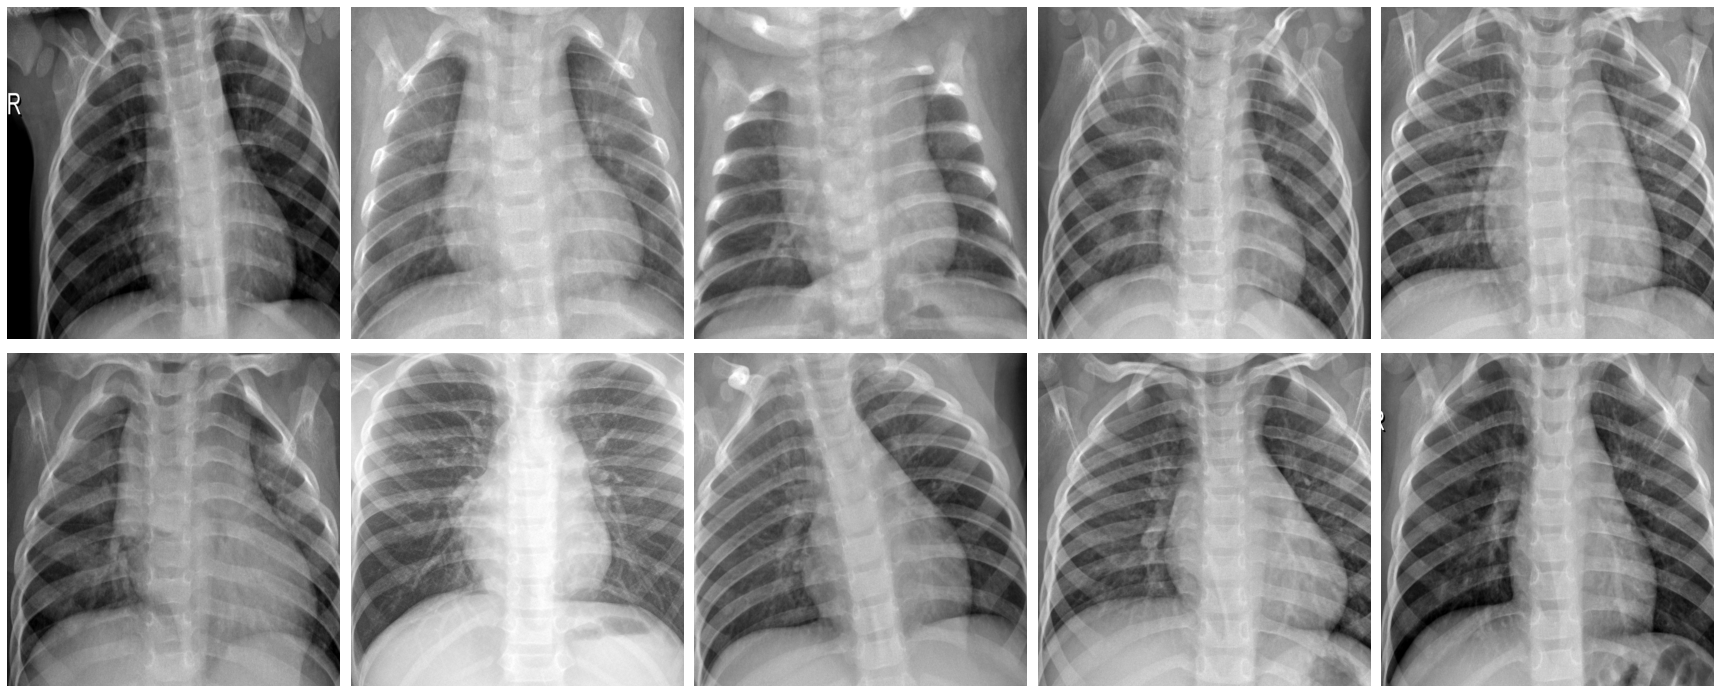

In [26]:
show_wrong_img(wrong_to_list(predIdxs, train))

### ON TEST

In [49]:
test = ImageDataGenerator(horizontal_flip = True,
                          shear_range=0.1,
                          fill_mode="constant",
                          rescale=1./255,
                          preprocessing_function = preprocessing,
                          validation_split=0.2).flow_from_directory('cropped/',
                                                                    target_size=(imgSize, imgSize),
                                                                    batch_size=BS,
                                                                    class_mode='categorical', 
                                                                    shuffle = False, 
                                                                    subset='validation')
CName = {v: k for k, v in test.class_indices.items()}
probabilities = []
for i in range(1+1):
    print('TTA Number: ', i, '\n')
    probabilities.append(model.predict(test, verbose=1))
predIdxs = np.mean(probabilities, axis=0)
predIdxs = np.argmax(predIdxs, axis=1)

Found 580 images belonging to 3 classes.
TTA Number:  0 

73/73 [==============================] - 56s 766ms/step
TTA Number:  1 

73/73 [==============================] - 57s 774ms/step


In [50]:
print(classification_report(test.labels, predIdxs, target_names=list(test.class_indices.keys()), digits = 5))

                 precision    recall  f1-score   support

       COVID-19    0.93478   1.00000   0.96629        43
         NORMAL    1.00000   0.84328   0.91498       268
Viral Pneumonia    0.87338   1.00000   0.93241       269

       accuracy                        0.92759       580
      macro avg    0.93605   0.94776   0.93789       580
   weighted avg    0.93644   0.92759   0.92687       580



In [51]:
for i in range(len(predIdxs)):
    if (predIdxs[i] != test.labels[i]):
        print('Filename:',test.filenames[i].split('/')[1], '\t'*(5-math.ceil((len(test.filenames[i].split('/')[1])+3)/8)) +'PRED:', CName[predIdxs[i]], '\t'*(4-(3+len(CName[predIdxs[i]]))//8) + 'TRUE:', CName[test.labels[i]])

Filename: NORMAL (1009).png 		PRED: Viral Pneumonia 		TRUE: NORMAL
Filename: NORMAL (1016).png 		PRED: Viral Pneumonia 		TRUE: NORMAL
Filename: NORMAL (1031).png 		PRED: COVID-19 			TRUE: NORMAL
Filename: NORMAL (1041).png 		PRED: Viral Pneumonia 		TRUE: NORMAL
Filename: NORMAL (1044).png 		PRED: Viral Pneumonia 		TRUE: NORMAL
Filename: NORMAL (1049).png 		PRED: Viral Pneumonia 		TRUE: NORMAL
Filename: NORMAL (1053).png 		PRED: Viral Pneumonia 		TRUE: NORMAL
Filename: NORMAL (106).png 		PRED: Viral Pneumonia 		TRUE: NORMAL
Filename: NORMAL (1064).png 		PRED: Viral Pneumonia 		TRUE: NORMAL
Filename: NORMAL (1075).png 		PRED: Viral Pneumonia 		TRUE: NORMAL
Filename: NORMAL (1078).png 		PRED: Viral Pneumonia 		TRUE: NORMAL
Filename: NORMAL (1080).png 		PRED: Viral Pneumonia 		TRUE: NORMAL
Filename: NORMAL (1088).png 		PRED: Viral Pneumonia 		TRUE: NORMAL
Filename: NORMAL (1089).png 		PRED: Viral Pneumonia 		TRUE: NORMAL
Filename: NORMAL (1091).png 		PRED: Viral Pneumonia 		TRUE: NORMAL
Fi

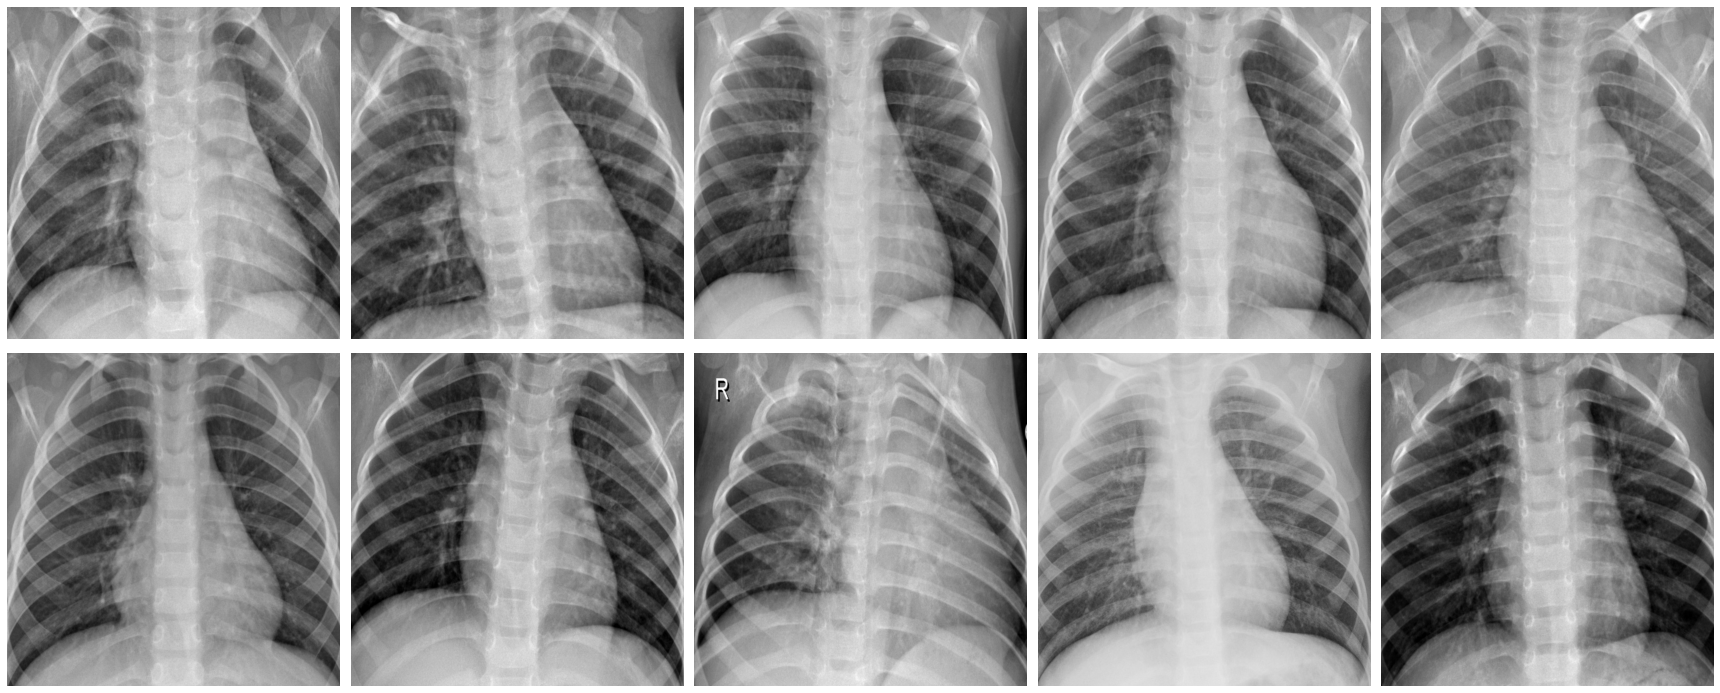

In [52]:
show_wrong_img(wrong_to_list(predIdxs, test))